In [1]:
from os import listdir
from os.path import isdir
import numpy as np

# function definition load datasets

In [2]:
# function load datasets

def load_datasets(dataset_directory):
    
    images_list = list()
    mask_list = list()
    path_list = list()
    for folder in listdir(dataset_directory):
        #get path
        path_folder = dataset_directory + folder + '/'
        
        if not isdir(path_folder):
            continue
        # save folder path  
        path_list.append(path_folder)
            
        if folder == "original_images":
            path_list.insert(0, path_folder)
            # get all skin images
            for filename in listdir(path_folder):
                images_list.append(filename)
        else:
            path_list.insert(1,path_folder)
            # get all skin mask
            for filename in listdir(path_folder):
                mask_list.append(filename)
        

    images_list.sort()
    mask_list.sort()
    print(">loaded {} examples of original images" .format(len(images_list)))
    print(">loaded {} examples of images mask" .format(len(mask_list)))
        
        
    return np.asarray(path_list), np.asarray(images_list), np.asarray(mask_list)

# load train set

In [3]:
path_files, list_of_files_train, list_of_mask_files_train = load_datasets("datasets/train/")

>loaded 1200 examples of original images
>loaded 1200 examples of images mask


# Display some train sample

In [4]:
from matplotlib import pyplot as plt
import cv2

image shape : (227, 227, 3)
image mask shape : (227, 227)


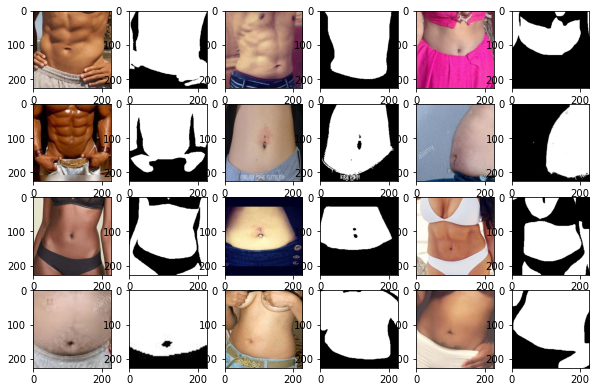

In [5]:
# list some examples
def display_some_sample(images_list = list_of_files_train, mask_list = list_of_mask_files_train, save_name="figures/dataset_abdomen.png"):
    
    np.random.seed(0)
    plt.figure(figsize=(10, 10))
    for k, i in np.ndenumerate(np.random.randint(images_list.shape[0], size=12)):
        ax = plt.subplot(6, 6, 2 * k[0] + 1)
        img = cv2.imread(path_files[0]+str(images_list[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        x = plt.subplot(6, 6, 2 * k[0] + 2)
        mask_img = cv2.imread(path_files[1]+str(mask_list[i]), 0)
        plt.imshow(mask_img, cmap='gray')
    plt.savefig(save_name)
    print("image shape : {}" .format(img.shape) )
    print("image mask shape : {}" .format(mask_img.shape) )
        

display_some_sample(images_list=list_of_files_train, mask_list=list_of_mask_files_train)

# Convert images to CIE LAB color space

In [6]:
def convert_to_lab(images_list= list_of_files_train, path_file=path_files[0]):
    list_images_channel_a = list()
    list_images_channel_b = list()
    for img_file in images_list:
        # set image path and read image
        path_img = path_file + str(img_file)
        img = cv2.imread(path_img)
        # convert image rgb to lab
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        _, a_channel, b_channel = cv2.split(img_lab)
        list_images_channel_a.append(a_channel)
        list_images_channel_b.append(b_channel)

    list_images_channel_a = np.array(list_images_channel_a, dtype=np.uint8)
    list_images_channel_b = np.array(list_images_channel_b, dtype=np.uint8)

    
    return list_images_channel_a, list_images_channel_b

In [7]:
list_images_channel_a, list_images_channel_b = convert_to_lab(images_list= list_of_files_train, path_file=path_files[0])

In [8]:
print("list images channel_a shape: {}" .format(list_images_channel_a.shape))
print("list images channel_b shape: {}" .format(list_images_channel_b.shape))

list images channel_a shape: (1200, 227, 227)
list images channel_b shape: (1200, 227, 227)


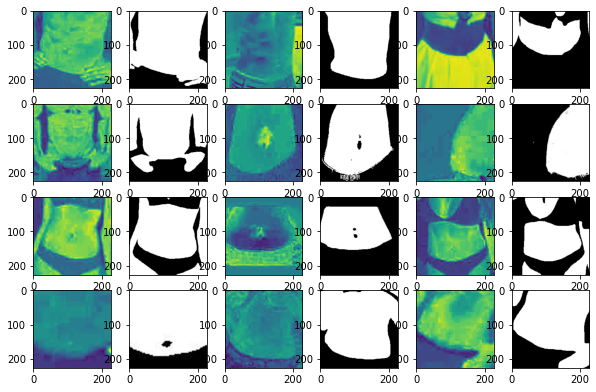

In [9]:
def display_some_sample_bis(images_list = list_images_channel_a, mask_list = list_of_mask_files_train, save_name="figures/dataset_abdomen_channel_a.png"):
    
    np.random.seed(0)
    plt.figure(figsize=(10, 10))
    for k, i in np.ndenumerate(np.random.randint(images_list.shape[0], size=12)):
        ax = plt.subplot(6, 6, 2 * k[0] + 1)
        plt.imshow(images_list[i])
        x = plt.subplot(6, 6, 2 * k[0] + 2)
        mask_img = cv2.imread(path_files[1]+str(mask_list[i]))
        plt.imshow(mask_img, cmap='gray')
    
    plt.savefig(save_name)

# some sample on a channel a
display_some_sample_bis(images_list=list_images_channel_a)

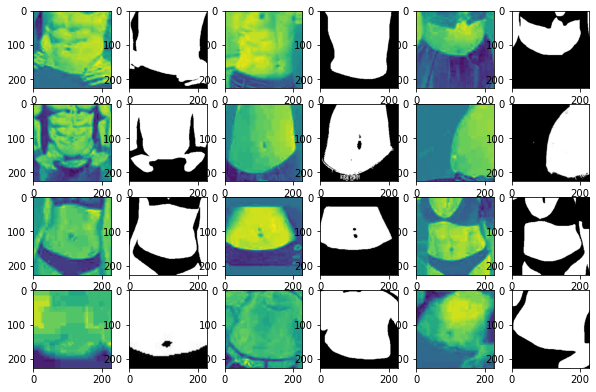

In [10]:
# some sample on b channels
display_some_sample_bis(images_list=list_images_channel_b , save_name="figures/dataset_abdomen_channel_b.png")

# contruct histogram of skin images and histogram of non skin image

In [11]:
# reduction of numbers of pixels
quantification_value = 32

def reduce_quantification(pixels_values = quantification_value , list_channel_a=list_images_channel_a, list_channel_b=list_images_channel_b):
    for k in range (list_channel_a.shape[0]):
        for i in range(list_channel_a.shape[1]):
            for j in range(list_channel_a.shape[1]):
                (list_channel_a[k])[i][j] = round(((list_channel_a[k])[i][j]) * pixels_values / 255)
                (list_channel_b[k])[i][j] = round(((list_channel_b[k])[i][j]) * pixels_values / 255)
                
    return list_channel_a, list_channel_b

# apply quantification reduction
list_channel_a, list_channel_b = reduce_quantification(pixels_values = quantification_value , list_channel_a=list_images_channel_a, list_channel_b=list_images_channel_b)

In [12]:
print("channel_a min value: {}\nchannel_a max value: {}" .format( np.min(list_channel_a), np.max(list_channel_a)))

channel_a min value: 7
channel_a max value: 27


In [13]:
print("channel_b min value: {}\nchannel_b max value: {}" .format( np.min(list_channel_b), np.max(list_channel_b)))

channel_b min value: 4
channel_b max value: 27


In [14]:
def histogram(list_channel_a=list_channel_a, list_channel_b= list_channel_b, list_mask= list_of_mask_files_train, pixels_checked = 255 ): 
    z_pixels = np.zeros((quantification_value, quantification_value))
    n , w, h = list_channel_a.shape[0],list_channel_a.shape[1], list_channel_a.shape[2]
    for k in range(n):
        img_mask = cv2.imread(path_files[1] + str(list_mask[k]), 0)
        for i in range(w):
            for j in range(h):    
                if img_mask[i][j] == pixels_checked :
                    x_a = (list_channel_a[k])[i][j]
                    y_b = (list_channel_b[k])[i][j]
                    z_pixels[x_a, y_b] += 1
    return z_pixels
    

In [15]:
from mpl_toolkits.mplot3d import Axes3D

# Draw skin histogram 

In [16]:
Z_pixels_skin = histogram(list_channel_a=list_channel_a, list_channel_b= list_channel_b, list_mask= list_of_mask_files_train, pixels_checked = 255 )

In [17]:
# create axes and draw
def graphic(Z = Z_pixels_skin, save_name="figures/histo_skin.png", title="Histogram skin"):
    X = np.linspace(0, quantification_value, quantification_value)
    Y = np.linspace(0, quantification_value, quantification_value)
    # create a grid
    X, Y = np.meshgrid(X,Y)
    print(X.shape, Y.shape)
    ax = plt.axes(projection='3d')
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('z')
    plt.title(title)
    Z = Z/np.sum(Z)
    ax.plot_surface(X, Y, Z, cmap = 'plasma')
    plt.savefig(save_name)

(32, 32) (32, 32)


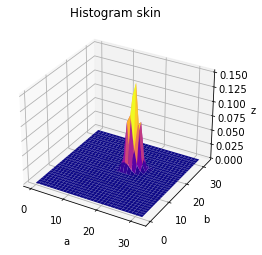

In [18]:
graphic(Z = Z_pixels_skin)

# Draw non skin histogram

In [19]:
Z_pixels_without_skin = histogram(list_channel_a=list_channel_a, list_channel_b= list_channel_b, list_mask= list_of_mask_files_train, pixels_checked = 0 )

(32, 32) (32, 32)


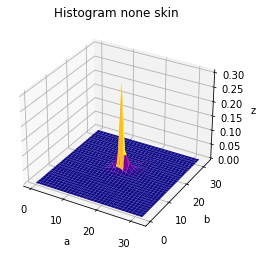

In [20]:
graphic(Z=Z_pixels_without_skin, save_name="figures/histo_non_skin.png", title="Histogram none skin")

# Add skin and none - skin images from SFA dataset of images from  35X35 pixels

In [21]:
# function load datasets

def load_datasets_bis(dataset_directory):
    
    skin_list = list()
    none_skin_list = list()
    path_list = list()
    for folder in listdir(dataset_directory):
        #get path
        path_folder = dataset_directory + folder + '/'
        
        if not isdir(path_folder):
            continue
        # save folder path  
        path_list.append(path_folder)
            
        if folder == "skin datasets":
            path_list.insert(0, path_folder)
            # get all skin images
            for filename in listdir(path_folder):
                skin_list.append(filename)
        else:
            path_list.insert(1,path_folder)
            # get all non skin 
            for filename in listdir(path_folder):
                none_skin_list.append(filename)
        
    print(">loaded {} examples of skin images" .format(len(skin_list)))
    print(">loaded {} examples of none skin images" .format(len(none_skin_list)))
        
        
    return np.asarray(path_list), np.asarray(skin_list), np.asarray(none_skin_list)



path_files_bis, list_of_skin_files_train_bis, list_of_non_skin_files_train_bis = load_datasets_bis("data_extracted_from_SFA/")

>loaded 3354 examples of skin images
>loaded 5590 examples of none skin images


# Display skin and non skin images

image shape : (35, 35, 3)


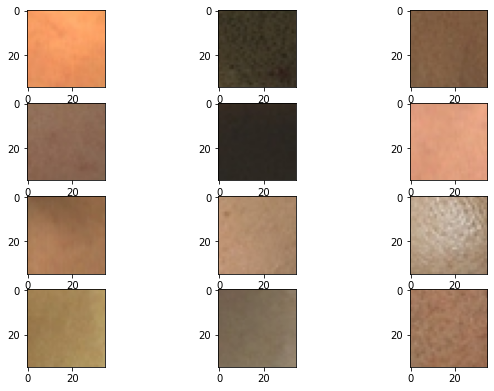

In [22]:
# list some examples
def display_images_sample(images_list = list_of_skin_files_train_bis, path_img = path_files_bis[0], save_name="figures/dataset_skin_multiracial.png"):
    
    np.random.seed(0)
    plt.figure(figsize=(10, 10))
    for k, i in np.ndenumerate(np.random.randint(images_list.shape[0], size=12)):
        ax = plt.subplot(6, 6, 2*k[0] + 1)
        img = cv2.imread(path_img+str(images_list[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        
    plt.savefig(save_name)
    print("image shape : {}" .format(img.shape) )
   
        

display_images_sample(images_list=list_of_skin_files_train_bis)

image shape : (35, 35, 3)


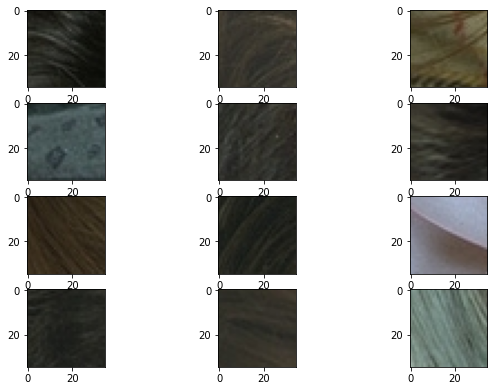

In [23]:
display_images_sample(images_list=list_of_non_skin_files_train_bis, path_img=path_files_bis[1] ,save_name="figures/dataset_non_skin.png")

In [24]:
# convert skin images to CIE LAB color space
list_skin_channel_a_bis, list_skin_channel_b_bis = convert_to_lab(images_list=list_of_skin_files_train_bis, path_file=path_files_bis[0])
print("list skin channel_a shape: {}" .format(list_skin_channel_a_bis.shape))
print("list skin channel_b shape: {}" .format(list_skin_channel_b_bis.shape))

list skin channel_a shape: (3354, 35, 35)
list skin channel_b shape: (3354, 35, 35)


In [25]:
# convert non skin images to CIE LAB color space
list_non_skin_channel_a_bis, list_non_skin_channel_b_bis = convert_to_lab(images_list=list_of_non_skin_files_train_bis, path_file=path_files_bis[1])
print("list none skin channel_a shape: {}" .format(list_non_skin_channel_a_bis.shape))
print("list none skin channel_b shape: {}" .format(list_non_skin_channel_b_bis.shape))

list none skin channel_a shape: (5590, 35, 35)
list none skin channel_b shape: (5590, 35, 35)


# display some samples of images skin and non skin from CIE LAB color space

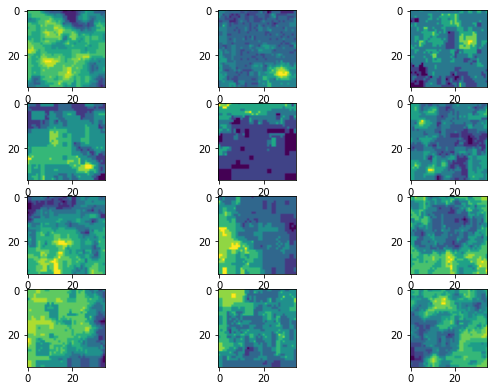

In [26]:
# list some examples
def display_images_sample_bis(images_list = list_skin_channel_a_bis, save_name="figures/dataset_skin_multiracial_channel_a.png"):
    
    np.random.seed(0)
    plt.figure(figsize=(10, 10))
    for k, i in np.ndenumerate(np.random.randint(images_list.shape[0], size=12)):
        ax = plt.subplot(6, 6, 2*k[0] + 1)
        plt.imshow(images_list[i])
   
    plt.savefig(save_name)
        
# images skin channel_a
display_images_sample_bis(images_list=list_skin_channel_a_bis)

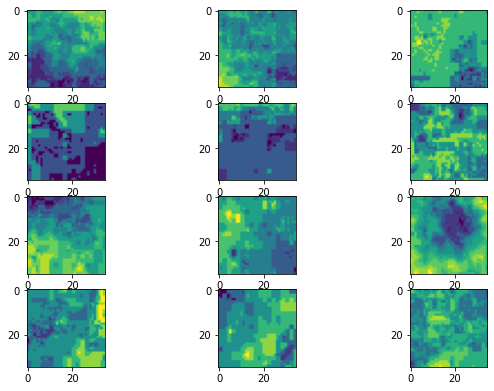

In [27]:
# images skin channel_b
display_images_sample_bis(images_list=list_skin_channel_b_bis,save_name="figures/dataset_skin_multiracial_channel_b.png")

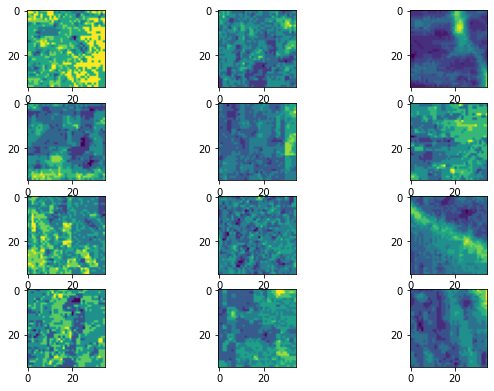

In [28]:
# images non skin channel_a
display_images_sample_bis(images_list=list_non_skin_channel_a_bis, save_name="figures/dataset_non_skin_channel_a.png")

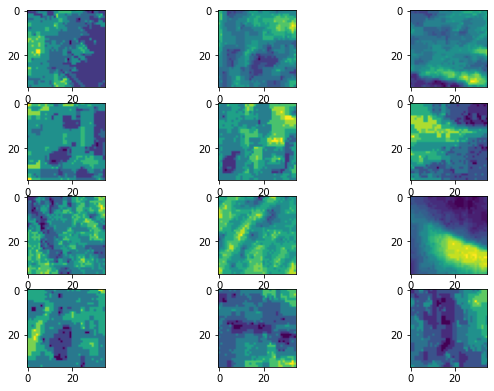

In [29]:
# images non skin channel_b
display_images_sample_bis(images_list=list_non_skin_channel_b_bis , save_name="figures/dataset_non_skin_channel_b.png" )

# Reduce images quantification 

In [30]:
# reduce values quantifications of skin images
list_skin_channel_a_bis, list_skin_channel_b_bis = reduce_quantification(pixels_values = quantification_value , list_channel_a=list_skin_channel_a_bis, list_channel_b=list_skin_channel_b_bis)
print("channel_a min value: {}\nchannel_a max value: {}\n\n" .format( np.min(list_skin_channel_a_bis), np.max(list_skin_channel_a_bis)))
print("channel_b min value: {}\nchannel_b max value: {}" .format( np.min(list_skin_channel_b_bis), np.max(list_skin_channel_b_bis)))

channel_a min value: 15
channel_a max value: 21


channel_b min value: 15
channel_b max value: 22


In [31]:
# reduce values quantifications of non skin images
list_non_skin_channel_a_bis, list_non_skin_channel_b_bis = reduce_quantification(pixels_values = quantification_value , list_channel_a=list_non_skin_channel_a_bis, list_channel_b=list_non_skin_channel_b_bis)
print("channel_a min value: {}\nchannel_a max value: {}\n\n" .format( np.min(list_non_skin_channel_a_bis), np.max(list_non_skin_channel_a_bis)))
print("channel_b min value: {}\nchannel_b max value: {}" .format( np.min(list_non_skin_channel_b_bis), np.max(list_non_skin_channel_b_bis)))

channel_a min value: 12
channel_a max value: 24


channel_b min value: 10
channel_b max value: 27


# Calculate Histogram for our adding images

In [32]:
def histogram_bis(list_channel_a=list_skin_channel_a_bis, list_channel_b= list_skin_channel_b_bis): 
    z_pixels = np.zeros((quantification_value, quantification_value))
    n , w, h = list_channel_a.shape[0],list_channel_a.shape[1], list_channel_a.shape[2]
    for k in range(n):
        for i in range(w):
            for j in range(h):    
                x_a = (list_channel_a[k])[i][j]
                y_b = (list_channel_b[k])[i][j]
                z_pixels[x_a, y_b] += 1
    return z_pixels
    

In [33]:
# histogram of skin images
Z_pixels_skin_bis = histogram_bis(list_channel_a=list_skin_channel_a_bis, list_channel_b= list_skin_channel_b_bis )

In [34]:
# histogram of skin images
Z_pixels_non_skin_bis = histogram_bis(list_channel_a=list_non_skin_channel_a_bis, list_channel_b= list_non_skin_channel_b_bis )

# Histogram augmentation and drawing

In [35]:
# histogram skin images augmented
Z_pixels_skin_added = Z_pixels_skin + Z_pixels_skin_bis

In [36]:
# histogram non skin images augmented
Z_pixels_non_skin_added = Z_pixels_without_skin + Z_pixels_non_skin_bis

(32, 32) (32, 32)


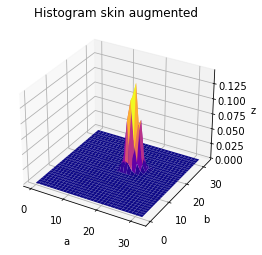

In [37]:
# draw skin histogram augmented
graphic(Z=Z_pixels_skin_added, save_name="figures/histo_skin_augmented.png", title="Histogram skin augmented")

(32, 32) (32, 32)


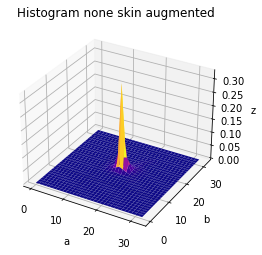

In [38]:
graphic(Z=Z_pixels_non_skin_added, save_name="figures/histo_non_skin_augmented.png", title="Histogram none skin augmented")

In [39]:
def graphic_contours(Z = Z_pixels_skin_added, save_name="figures/histo_skin.png", title="Contour plot skin augmented"):
    X = np.linspace(0, quantification_value, quantification_value)
    Y = np.linspace(0, quantification_value, quantification_value)
    # create a grid
    X, Y = np.meshgrid(X,Y)
    print(X.shape, Y.shape)
    Z = Z / np.sum(Z)
    plt.contourf(X,Y,Z,20, cmap='RdGy')
    plt.colorbar()
    plt.xlabel('a')
    plt.ylabel('b')
    plt.title(title)
    plt.savefig(save_name)
    

def graphic_contours_bis(Z = Z_pixels_skin_added, save_name="figures/histo_skin.png", title="Contour plot skin augmented"):
    X = np.linspace(0, quantification_value, quantification_value)
    Y = np.linspace(0, quantification_value, quantification_value)
    # create a grid
    X, Y = np.meshgrid(X,Y)
    print(X.shape, Y.shape)
    Z = Z / np.sum(Z)
    plt.contour(X,Y,Z,20,colors='black') 
    plt.xlabel('a')
    plt.ylabel('b')
    plt.title(title)
    plt.savefig(save_name)

(32, 32) (32, 32)


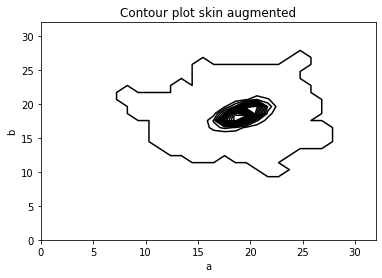

In [40]:
graphic_contours_bis(Z = Z_pixels_skin_added, save_name="figures/contours_skin_augmented_bis.png")

(32, 32) (32, 32)


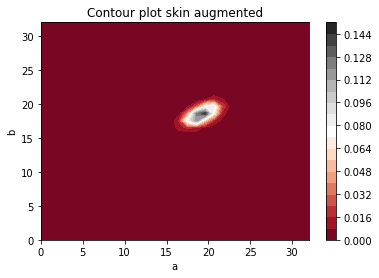

In [41]:
graphic_contours(Z = Z_pixels_skin_added, save_name="figures/contours_skin_augmented.png")

(32, 32) (32, 32)


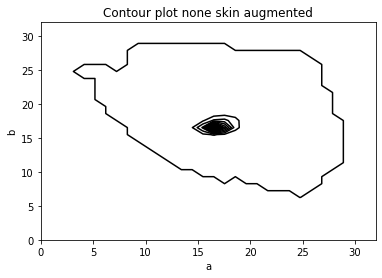

In [42]:
graphic_contours_bis(Z = Z_pixels_non_skin_added, save_name="figures/contours_non_skin_augmented_bis.png", title="Contour plot none skin augmented")

(32, 32) (32, 32)


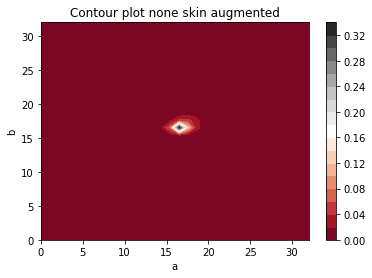

In [43]:
graphic_contours(Z = Z_pixels_non_skin_added, save_name="figures/contours_none_skin_augmented.png", title="Contour plot none skin augmented")

# Design model

## Define total pixels, and total skin and non skin pixels

In [44]:
# number of skin pixels

sum_skin_pixels = np.sum(Z_pixels_skin)
sum_skin_pixels_bis = np.sum(Z_pixels_skin_bis)
sum_skin_pixels_augmented = np.sum(Z_pixels_skin_added)
print("total pixels skin before augmented : {}".format(sum_skin_pixels))
print("total pixels skin added : {}".format(sum_skin_pixels_bis))
print("total pixels skin after augmented : {}".format(sum_skin_pixels_augmented))

total pixels skin before augmented : 39671842.0
total pixels skin added : 4108650.0
total pixels skin after augmented : 43780492.0


In [45]:
# number of non skin pixels

sum_non_skin_pixels = np.sum(Z_pixels_without_skin)
sum_non_skin_pixels_bis = np.sum(Z_pixels_non_skin_bis)
sum_non_skin_pixels_augmented = np.sum(Z_pixels_non_skin_added)
print("total pixels non skin before augmented : {}".format(sum_non_skin_pixels))
print("total pixels non skin added : {}".format(sum_non_skin_pixels_bis))
print("total pixels non skin after augmented : {}".format(sum_non_skin_pixels_augmented))

total pixels non skin before augmented : 20541824.0
total pixels non skin added : 6847750.0
total pixels non skin after augmented : 27389574.0


In [46]:
# total pixels images
total_pixels = sum_skin_pixels_augmented + sum_non_skin_pixels_augmented
print("total pixels skin and non skin : {}".format(total_pixels))

total pixels skin and non skin : 71170066.0


# save our histogram 

In [47]:
# save initial histogram skin
np.savetxt("histogram_save_models/histo_skin_init.txt", Z_pixels_skin / np.sum(Z_pixels_skin), fmt="%f")

In [48]:
# save initial histogram none skin
np.savetxt("histogram_save_models/histo_none_skin_init.txt", Z_pixels_without_skin / np.sum(Z_pixels_without_skin), fmt="%f")

In [49]:
# save histogram skin added
np.savetxt("histogram_save_models/histo_skin_added.txt", Z_pixels_skin_bis / np.sum(Z_pixels_skin_bis), fmt="%f")

In [50]:
# save histogram none skin added
np.savetxt("histogram_save_models/histo_none_skin_added.txt", Z_pixels_non_skin_bis / np.sum(Z_pixels_non_skin_bis), fmt="%f")

In [51]:
# save histogram skin augmented
np.savetxt("histogram_save_models/histo_skin_augmented.txt", Z_pixels_skin_added / np.sum(Z_pixels_skin_added), fmt="%f")

In [52]:
# save histogram none skin augmented
np.savetxt("histogram_save_models/histo_none_skin_augmented.txt", Z_pixels_non_skin_added / np.sum(Z_pixels_non_skin_added), fmt="%f")

# set histogram normalized 

In [53]:
histo_skin = np.loadtxt("histogram_save_models/histo_skin_augmented.txt", dtype=float)
histo_none_skin = np.loadtxt("histogram_save_models/histo_none_skin_augmented.txt", dtype=float)

# evaluate skin and none skin pixel from histogram based 

In [54]:
print ("mean skin probability: ", np.mean(histo_skin > 0))
print ("mean non skin probability: ",np.mean(histo_none_skin > 0), end="\n\n")
print ("min skin probability: {:.9f}" .format(np.min(histo_skin[np.nonzero(histo_skin)])))
print ("max skin probability: ",np.max(histo_skin), end="\n\n")
print ("min none skin probability: {:.9f}" .format(np.min(histo_none_skin[np.nonzero(histo_none_skin)])))
print ("max none skin probability: ",np.max(histo_none_skin))

mean skin probability:  0.1396484375
mean non skin probability:  0.306640625

min skin probability: 0.000001000
max skin probability:  0.144279

min none skin probability: 0.000001000
max none skin probability:  0.325363


In [55]:
def evaluate_from_histogram(a_pixel, b_pixel, histo_skin= histo_skin, histo_none_skin=histo_none_skin, threshold=0.15):
    # set threshold minimal
    THRESHOLD_MIN = 0.045
    is_skin = (histo_skin[a_pixel, b_pixel] > THRESHOLD_MIN and histo_skin[a_pixel, b_pixel] < threshold)
    #print("Is pixel probability {} same like skin? {}".format(histo_skin[a_pixel, b_pixel], is_skin))
    return is_skin

# evaluate skin and none skin pixel from bayes method based

In [56]:
# set prior probabilities from skin and none skin

prior_prob_skin = sum_skin_pixels_augmented / total_pixels
prior_prob_none_skin = sum_non_skin_pixels_augmented / total_pixels

print("Skin probability : {:.3f}\nNone skin probabilities : {:.3f}" .format(prior_prob_skin, prior_prob_none_skin))

Skin probability : 0.615
None skin probabilities : 0.385


In [57]:
def evaluate_from_bayes_method(a_pixel, b_pixel, histo_skin= histo_skin, histo_none_skin=histo_none_skin, threshold = 0.7):
    likelihood_skin = histo_skin[a_pixel, b_pixel]
    likelihood_none_skin = histo_none_skin[a_pixel, b_pixel]
    posterior_skin = (likelihood_skin * prior_prob_skin) / (likelihood_skin * prior_prob_skin + likelihood_none_skin * prior_prob_none_skin)
    is_skin = posterior_skin > threshold
    #print("Is pixel probability {} same like skin? {}".format(posterior_skin, is_skin))
    return is_skin

# Load test set

In [58]:
path_files, list_of_files_test, list_of_mask_files_test = load_datasets("datasets/test/")

>loaded 200 examples of original images
>loaded 200 examples of images mask


# display some test set sample

image shape : (227, 227, 3)
image mask shape : (227, 227)


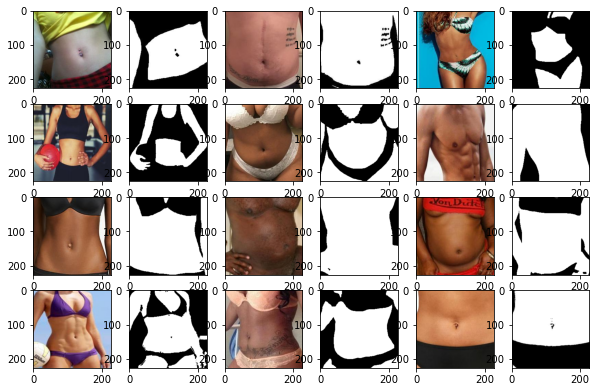

In [59]:
display_some_sample(images_list = list_of_files_test, mask_list = list_of_mask_files_test, save_name="figures/dataset_abdomen_test.png")

# Change color space to CIE LAB color space

In [60]:
list_test_channel_a, list_test_channel_b = convert_to_lab(images_list= list_of_files_test, path_file=path_files[0])

# Display test sample channel a

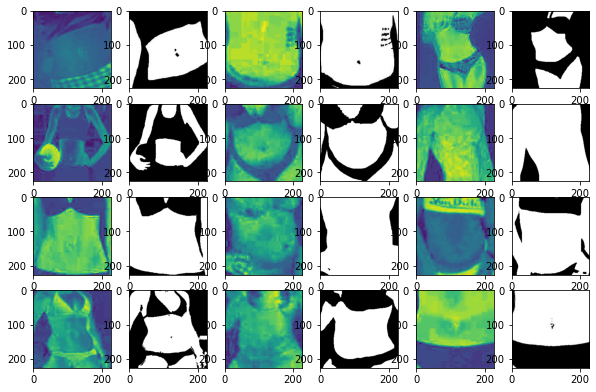

In [61]:
display_some_sample_bis(images_list = list_test_channel_a, mask_list = list_of_mask_files_test, save_name="figures/dataset_abdomen_test_channel_a.png")

# Display test sample channel b

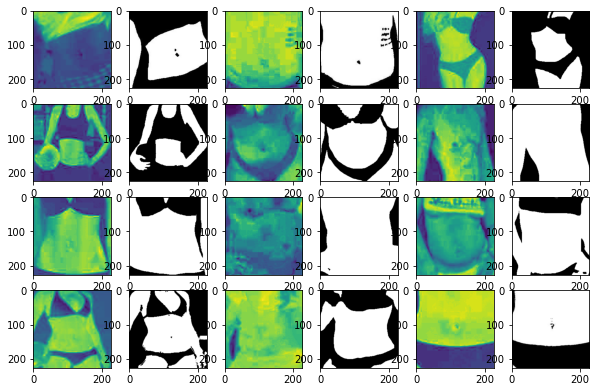

In [62]:
display_some_sample_bis(images_list = list_test_channel_b, mask_list = list_of_mask_files_test, save_name="figures/dataset_abdomen_test_channel_b.png")

# Reduce quantification

In [63]:
list_test_channel_a, list_test_channel_b = reduce_quantification(pixels_values = quantification_value , list_channel_a=list_test_channel_a, list_channel_b=list_test_channel_b)

In [64]:
print("test channel_a min value: {}\ntest channel_a max value: {}" .format( np.min(list_test_channel_a), np.max(list_test_channel_a)))

test channel_a min value: 8
test channel_a max value: 26


In [65]:
print("test channel_b min value: {}\ntest channel_b max value: {}" .format( np.min(list_test_channel_b), np.max(list_test_channel_b)))

test channel_b min value: 6
test channel_b max value: 27


# Define our predict model
from each test skin images in CIE LAB color space, predict mask label 

In [66]:
def model_predict(evaluate_method_based = 0, test_channel_a=list_test_channel_a, test_channel_b=list_test_channel_b, test_list=list_of_files_test, threshold_value=0.6):
    
    list_predict_mask = list()
    #print(test_channel_a.shape[0], test_channel_a.shape[1], test_channel_a.shape[2])
    n , w, h = test_channel_a.shape[0], test_channel_a.shape[1], test_channel_a.shape[2]
    for k in range(n):
        # read current test image in gray scale
        img = cv2.imread(path_files[0] + str(test_list[k]), 0)
        for i in range(w):
            for j in range(h):   
                # get a and b channel value
                a = (test_channel_a[k])[i][j]
                b = (test_channel_b[k])[i][j]
                
                # evaluate current pixel to skin or none skin
                if evaluate_method_based == 0:
                    is_skin = evaluate_from_histogram(a_pixel=a, b_pixel=b, histo_skin= histo_skin, histo_none_skin=histo_none_skin, threshold=threshold_value)
                else:
                    is_skin = evaluate_from_bayes_method(a_pixel=a, b_pixel=b, histo_skin= histo_skin, histo_none_skin=histo_none_skin, threshold=threshold_value)
                # set pixel test image to 255 if is_kin egal true, else 0
                if is_skin:
                    img[i][j] = 255
                else:
                    img[i][j] = 0
        
        # add predict label to list
        list_predict_mask.append(img)
        
    return np.asarray(list_predict_mask)

# Define our confusion matrix as our model metric

In [67]:
def model_metric_confusion(list_predict_label = None, list_label = None):
    
    n , w, h = list_predict_label.shape[0], list_predict_label.shape[1], list_predict_label.shape[2]
    confusion_matrix = np.zeros((2,2)) # TP at (0,1), FN at (0,2), FP at (1,0) and TN at (1,1)
    # set skin pixel default value 
    skin_pixel = 255
    for k in range(n):
        # get mask label and predict
        label_mask = cv2.imread(path_files[1]+str(list_label[k]), 0)
        predict_mask = list_predict_label[k]
        for i in range(w):
            for j in range(h):
                # compare mask and construct confusion matrix
                if label_mask[i][j] == skin_pixel:
                    if predict_mask[i][j] == skin_pixel:
                        confusion_matrix[0,0] += 1 # TP: True positive
                    else:
                        confusion_matrix[1,0] += 1 # FP: False positive
                else:
                    if predict_mask[i][j] == skin_pixel:
                        confusion_matrix[0,1] += 1 # FN: False negative
                    else:
                        confusion_matrix[1,1] += 1 # TN: True negative
                        
    # return confusion matrix
    return confusion_matrix
    

# Make prediction using histogram based approach

In [68]:
THRESHOLD_HISTO = 0.15
THRESHOLD_BAYES = 0.74

In [69]:
predict_mask_list_1 = model_predict(evaluate_method_based= 0, test_channel_a=list_test_channel_a, test_channel_b=list_test_channel_b, test_list=list_of_files_test, threshold_value=THRESHOLD_HISTO)

In [70]:
predict_mask_list_2 = model_predict(evaluate_method_based = 1, test_channel_a=list_test_channel_a, test_channel_b=list_test_channel_b, test_list=list_of_files_test, threshold_value=THRESHOLD_BAYES)

/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


# Display some prediction sample using histogram based approach 

In [71]:
# list some examples
def display_some_sample_bis(images_list = list_of_files_test, mask_list = None, save_name="figures/dataset_abdomen.png"):
    
    np.random.seed(0)
    plt.figure(figsize=(10, 10))
    for k, i in np.ndenumerate(np.random.randint(images_list.shape[0], size=12)):
        ax = plt.subplot(6, 6, 2 * k[0] + 1)
        img = cv2.imread(path_files[0]+str(images_list[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        x = plt.subplot(6, 6, 2 * k[0] + 2)
        mask_img = mask_list[i]
        plt.imshow(mask_img, cmap='gray')
    plt.savefig(save_name)
    print("image shape : {}" .format(img.shape) )
    mask_img = np.expand_dims(mask_img,axis=0)
    print("image mask shape : {}" .format(mask_img.shape) )

image shape : (227, 227, 3)
image mask shape : (1, 227, 227)


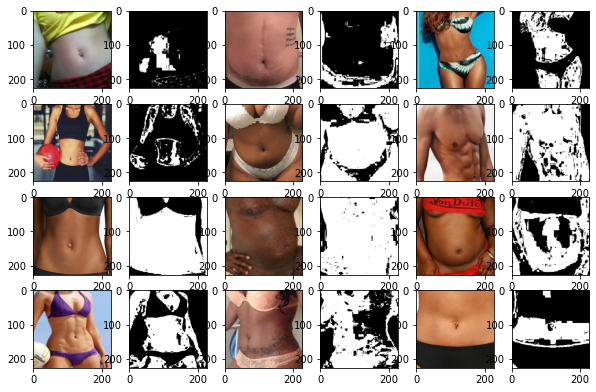

In [72]:
display_some_sample_bis(images_list = list_of_files_test, mask_list = predict_mask_list_1, save_name="figures/dataset_test_predict.png")

# Display some prediction sample using Bayes based approach

image shape : (227, 227, 3)
image mask shape : (1, 227, 227)


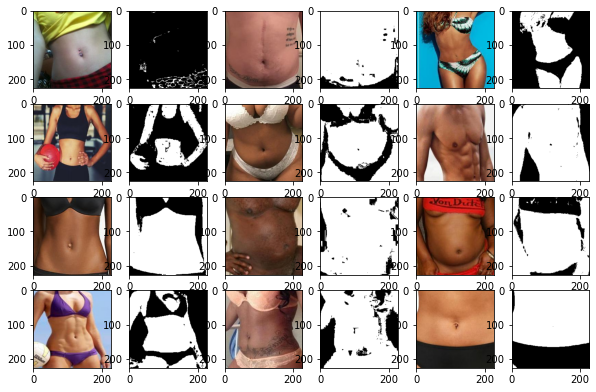

In [73]:
display_some_sample_bis(images_list = list_of_files_test, mask_list = predict_mask_list_2, save_name="figures/dataset_test_predict_bayes.png")

# get confusion matrix  

In [74]:
# confusion matrix Histogram approach
confusion_matrix_1 =  model_metric_confusion(list_predict_label = predict_mask_list_1, list_label = list_of_mask_files_test)

In [75]:
# confusion matrix Bayes method approach
confusion_matrix_2 =  model_metric_confusion(list_predict_label = predict_mask_list_2, list_label = list_of_mask_files_test)

# get metrics

In [76]:
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[0,0] / sum(cf[:,0])
            recall    = cf[0,0] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Metric Histogram based approach

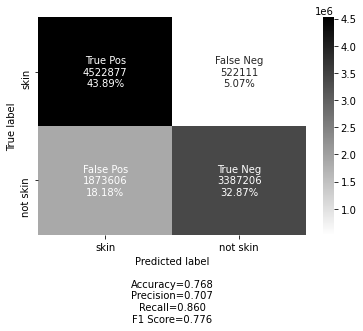

In [77]:
_labels = ['True Pos','False Neg','False Pos','True Neg']
labels = ("skin", "not skin")
make_confusion_matrix(confusion_matrix_1, group_names=_labels,categories=labels, cmap='binary')

# Metric Bayes method approach

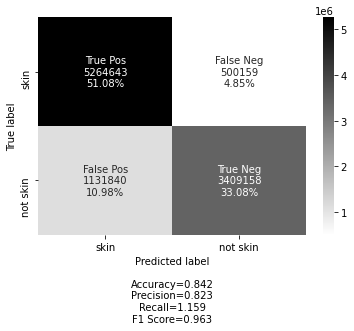

In [78]:
make_confusion_matrix(confusion_matrix_2, group_names=_labels,categories=labels, cmap='binary')

# Model detection
predict new entry image 

In [79]:
def model_detector(img_test_path = None, evaluate_method = 0, threshold=0.69):
    
    # read image
    img = cv2.imread(img_test_path)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_original = img.copy()
    # convert image bgr to lab
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    _, channel_a, channel_b= cv2.split(img_lab)
    
    # reduce quantification and predict 
    pixels_values = 32
    for i in range(channel_a.shape[0]):
            for j in range(channel_a.shape[1]):
                # quantification pixel
                channel_a[i][j] = round((channel_a[i][j] * pixels_values) / 255)
                channel_b[i][j] = round((channel_b[i][j] * pixels_values) / 255)
                
                # predict pixel
                a = channel_a[i][j]
                b = channel_b[i][j]
                   
                # evaluate current pixel to skin or none skin
                if evaluate_method == 0:
                    is_skin =  evaluate_from_histogram(a_pixel=a, b_pixel=b, histo_skin= histo_skin, histo_none_skin=histo_none_skin, threshold=threshold)
                else: 
                    is_skin = evaluate_from_bayes_method(a_pixel=a, b_pixel=b, histo_skin= histo_skin, histo_none_skin=histo_none_skin, threshold=threshold)
                
                # set pixel to 0 if is_skin egal false 
                if not is_skin:
                    img[i][j] = 0
    
    # original image and predict image
    return img_original, img

In [80]:
original_img_1, detected_img_1 = model_detector(img_test_path = "test_images/test3.jpeg", evaluate_method = 0, threshold=THRESHOLD_HISTO)
original_img_2, detected_img_2 = model_detector(img_test_path = "test_images/test3.jpeg", evaluate_method = 1, threshold=THRESHOLD_BAYES)

In [81]:
# list some examples
def display_detected(img = original_img_2 , detected_img = detected_img_2 , save_name="figures/test0.png"):

    plt.figure(figsize=(10, 10))
    
    ax = plt.subplot(2, 1, 1)
    plt.imshow(img)
    x = plt.subplot(2, 1, 2)
    plt.imshow(detected_img, cmap='gray')
    plt.savefig(save_name)
    print("Original image shape : {}" .format(img.shape) )
    print("Detected image shape : {}" .format(detected_img.shape) )

Original image shape : (183, 275, 3)
Detected image shape : (183, 275, 3)


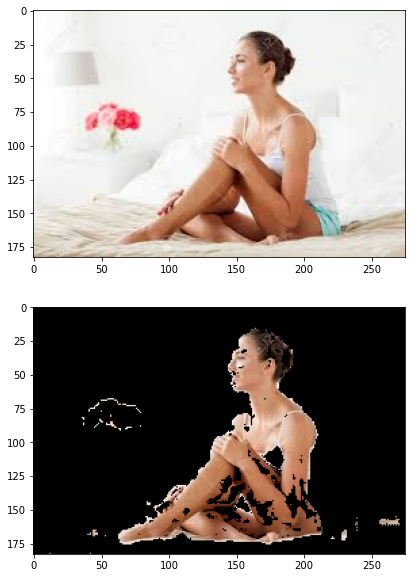

In [82]:
display_detected(img = original_img_1, detected_img = detected_img_1 , save_name="figures/test_histo_0.png")

Original image shape : (183, 275, 3)
Detected image shape : (183, 275, 3)


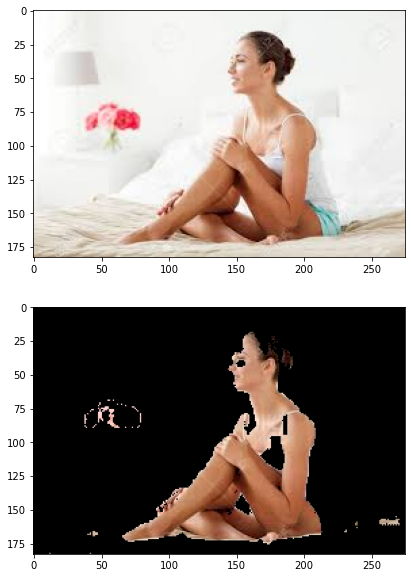

In [83]:
display_detected(img = original_img_2, detected_img = detected_img_2 , save_name="figures/test_bayes_0.png")

In [84]:
original_img_1, detected_img_1 = model_detector(img_test_path = "test_images/test1.jpeg", evaluate_method = 0, threshold=THRESHOLD_HISTO)
original_img_2, detected_img_2 = model_detector(img_test_path = "test_images/test1.jpeg", evaluate_method = 1, threshold=THRESHOLD_BAYES)

Original image shape : (183, 275, 3)
Detected image shape : (183, 275, 3)


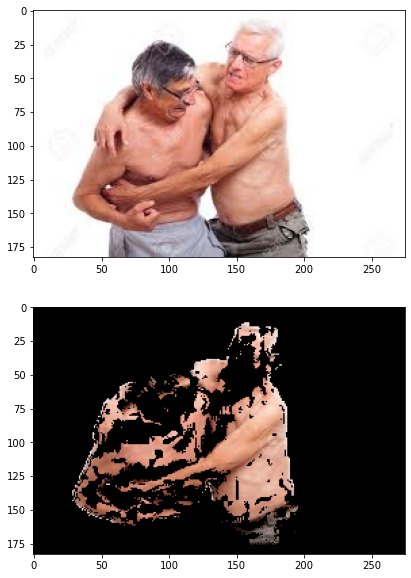

In [85]:
display_detected(img = original_img_1, detected_img = detected_img_1 , save_name="figures/test_histo_1.png")

Original image shape : (183, 275, 3)
Detected image shape : (183, 275, 3)


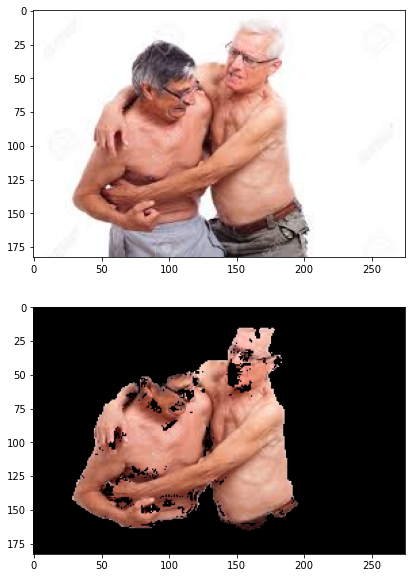

In [86]:
display_detected(img = original_img_2, detected_img = detected_img_2 , save_name="figures/test_bayes_1.png")

In [87]:
original_img_1, detected_img_1 = model_detector(img_test_path = "test_images/test2.jpeg", evaluate_method = 0, threshold=THRESHOLD_HISTO)
original_img_2, detected_img_2 = model_detector(img_test_path = "test_images/test2.jpeg", evaluate_method = 1, threshold=THRESHOLD_BAYES)

Original image shape : (159, 318, 3)
Detected image shape : (159, 318, 3)


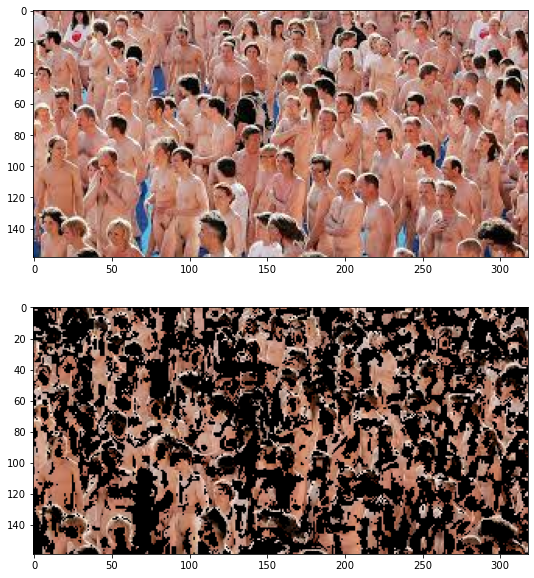

In [88]:
display_detected(img = original_img_1, detected_img = detected_img_1 , save_name="figures/test_histo_2.png")

Original image shape : (159, 318, 3)
Detected image shape : (159, 318, 3)


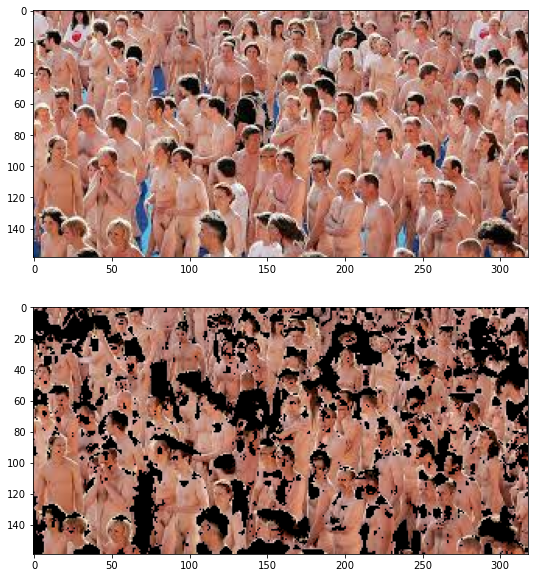

In [89]:
display_detected(img = original_img_2, detected_img = detected_img_2 , save_name="figures/test_bayes_2.png")

In [90]:
original_img_1, detected_img_1 = model_detector(img_test_path = "test_images/test0.jpeg", evaluate_method = 0, threshold=THRESHOLD_HISTO)
original_img_2, detected_img_2 = model_detector(img_test_path = "test_images/test0.jpeg", evaluate_method = 1, threshold=THRESHOLD_BAYES)

Original image shape : (163, 310, 3)
Detected image shape : (163, 310, 3)


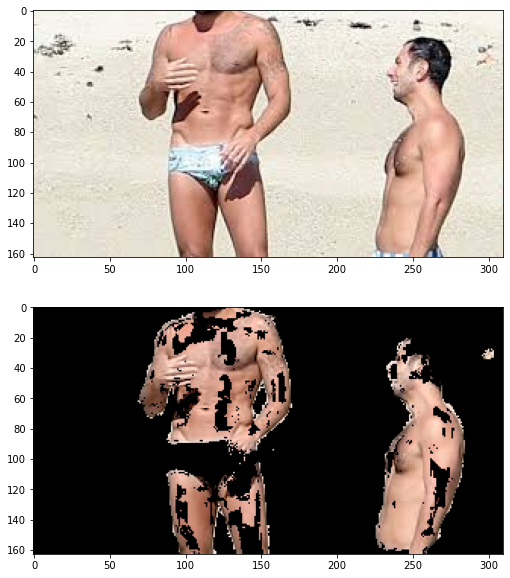

In [91]:
display_detected(img = original_img_1, detected_img = detected_img_1 , save_name="figures/test_histo_3.png")

Original image shape : (163, 310, 3)
Detected image shape : (163, 310, 3)


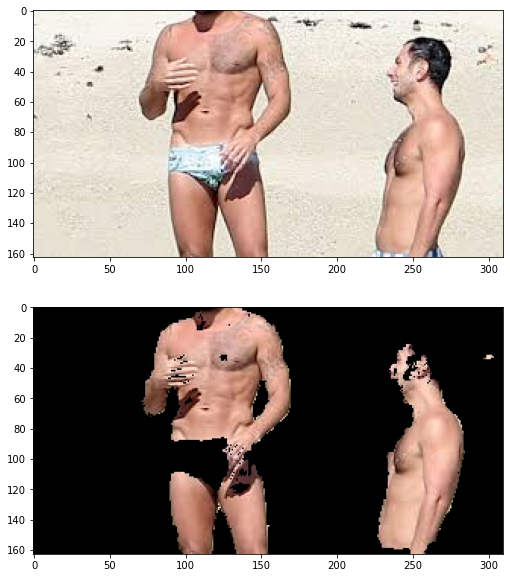

In [92]:
display_detected(img = original_img_2, detected_img = detected_img_2 , save_name="figures/test_bayes_3.png")

In [93]:
original_img_1, detected_img_1 = model_detector(img_test_path = "test_images/test4.jpeg", evaluate_method = 0, threshold=THRESHOLD_HISTO)
original_img_2, detected_img_2 = model_detector(img_test_path = "test_images/test4.jpeg", evaluate_method = 1, threshold=THRESHOLD_BAYES)

Original image shape : (172, 293, 3)
Detected image shape : (172, 293, 3)


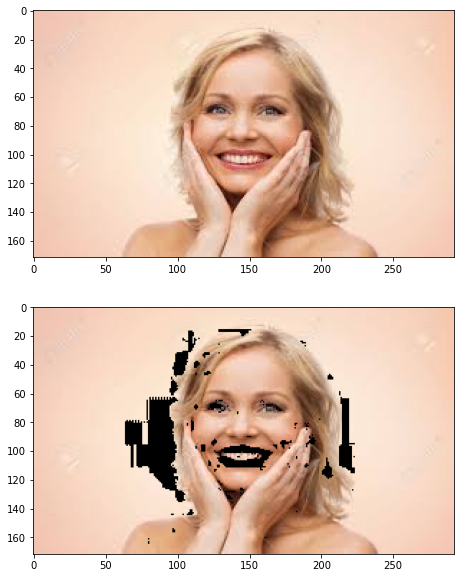

In [94]:
display_detected(img = original_img_1, detected_img = detected_img_1 , save_name="figures/test_histo_4.png")

Original image shape : (172, 293, 3)
Detected image shape : (172, 293, 3)


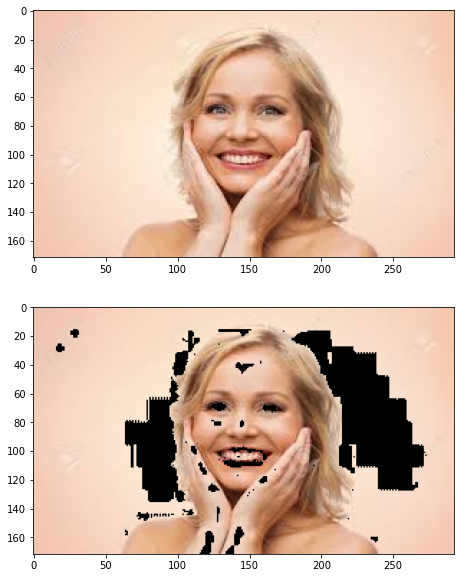

In [95]:
display_detected(img = original_img_2, detected_img = detected_img_2 , save_name="figures/test_bayes_4.png")

In [96]:
original_img_1, detected_img_1 = model_detector(img_test_path = "test_images/test5.jpeg", evaluate_method = 0, threshold=THRESHOLD_HISTO)
original_img_2, detected_img_2 = model_detector(img_test_path = "test_images/test5.jpeg", evaluate_method = 1, threshold=THRESHOLD_BAYES)

Original image shape : (193, 261, 3)
Detected image shape : (193, 261, 3)


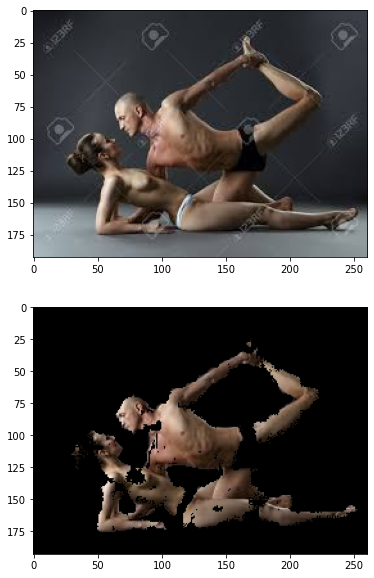

In [97]:
display_detected(img = original_img_1, detected_img = detected_img_1 , save_name="figures/test_histo_5.png")

Original image shape : (193, 261, 3)
Detected image shape : (193, 261, 3)


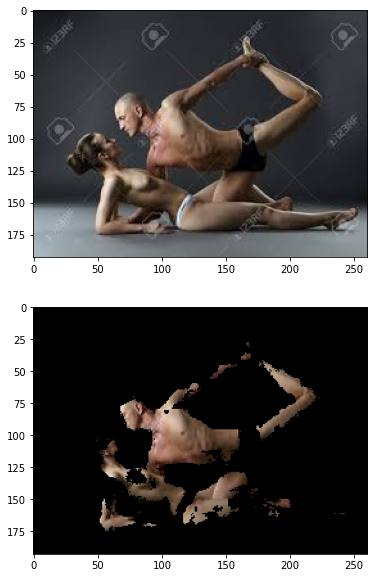

In [98]:
display_detected(img = original_img_2, detected_img = detected_img_2 , save_name="figures/test_bayes_5.png")

In [99]:
original_img_1, detected_img_1 = model_detector(img_test_path = "test_images/test6.jpeg", evaluate_method = 0, threshold=THRESHOLD_HISTO)
original_img_2, detected_img_2 = model_detector(img_test_path = "test_images/test6.jpeg", evaluate_method = 1, threshold=THRESHOLD_BAYES)

Original image shape : (186, 271, 3)
Detected image shape : (186, 271, 3)


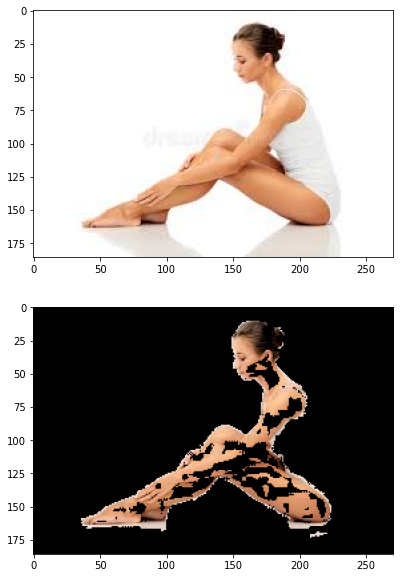

In [100]:
display_detected(img = original_img_1, detected_img = detected_img_1 , save_name="figures/test_histo_6.png")

Original image shape : (186, 271, 3)
Detected image shape : (186, 271, 3)


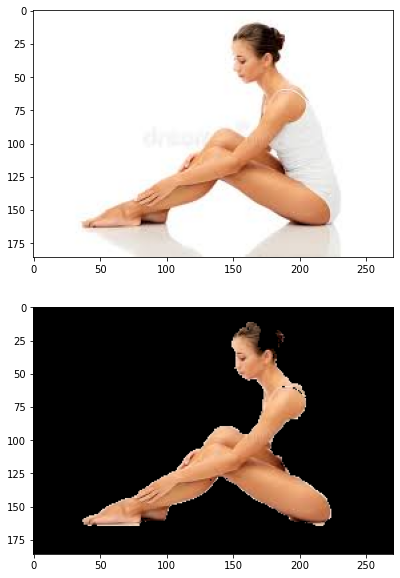

In [101]:
display_detected(img = original_img_2, detected_img = detected_img_2 , save_name="figures/test_bayes_6.png")

In [102]:
original_img_1, detected_img_1 = model_detector(img_test_path = "test_images/test7.jpeg", evaluate_method = 0, threshold=THRESHOLD_HISTO)
original_img_2, detected_img_2 = model_detector(img_test_path = "test_images/test7.jpeg", evaluate_method = 1, threshold=THRESHOLD_BAYES)

Original image shape : (183, 275, 3)
Detected image shape : (183, 275, 3)


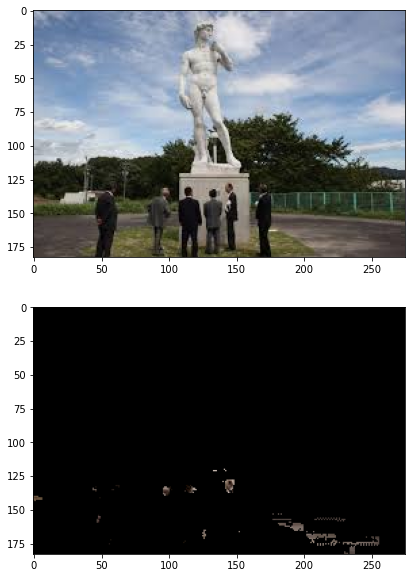

In [103]:
display_detected(img = original_img_1, detected_img = detected_img_1 , save_name="figures/test_histo_7.png")

Original image shape : (183, 275, 3)
Detected image shape : (183, 275, 3)


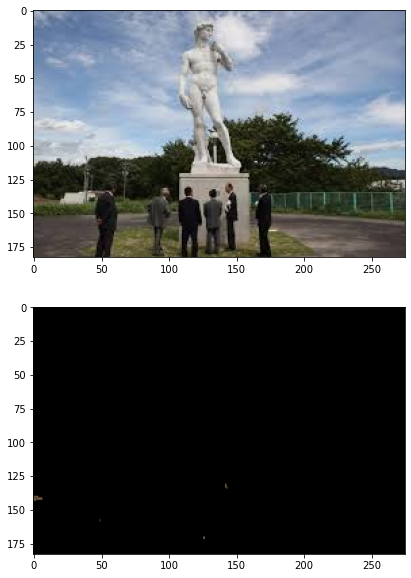

In [104]:
display_detected(img = original_img_2, detected_img = detected_img_2 , save_name="figures/test_bayes_7.png")

In [105]:
original_img_1, detected_img_1 = model_detector(img_test_path = "test_images/test8.jpeg", evaluate_method = 0, threshold=THRESHOLD_HISTO)
original_img_2, detected_img_2 = model_detector(img_test_path = "test_images/test8.jpeg", evaluate_method = 1, threshold=THRESHOLD_BAYES)

Original image shape : (164, 307, 3)
Detected image shape : (164, 307, 3)


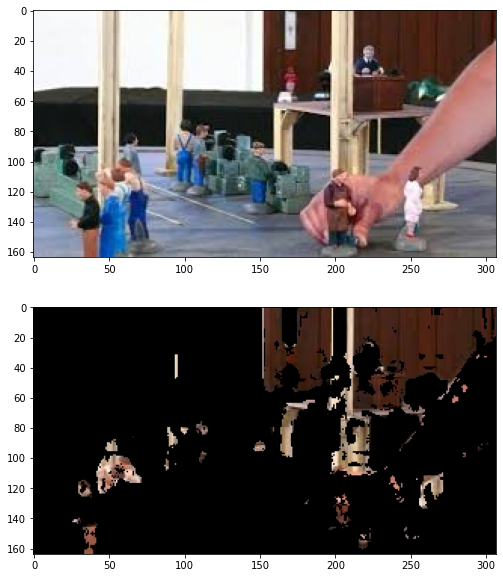

In [106]:
display_detected(img = original_img_1, detected_img = detected_img_1 , save_name="figures/test_histo_8.png")

Original image shape : (164, 307, 3)
Detected image shape : (164, 307, 3)


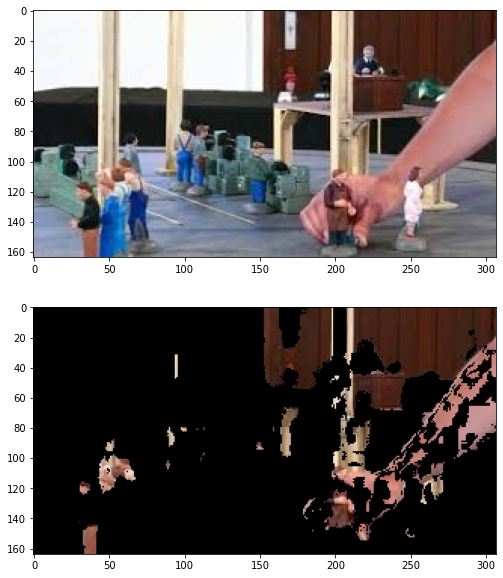

In [107]:
display_detected(img = original_img_2, detected_img = detected_img_2 , save_name="figures/test_bayes_8.png")

In [108]:
original_img_1, detected_img_1 = model_detector(img_test_path = "test_images/test9.jpeg", evaluate_method = 0, threshold=THRESHOLD_HISTO)
original_img_2, detected_img_2 = model_detector(img_test_path = "test_images/test9.jpeg", evaluate_method = 1, threshold=THRESHOLD_BAYES)

Original image shape : (275, 183, 3)
Detected image shape : (275, 183, 3)


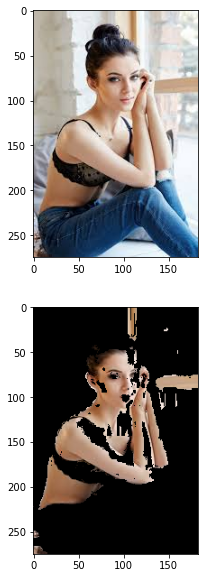

In [109]:
display_detected(img = original_img_1, detected_img = detected_img_1 , save_name="figures/test_histo_9.png")

Original image shape : (275, 183, 3)
Detected image shape : (275, 183, 3)


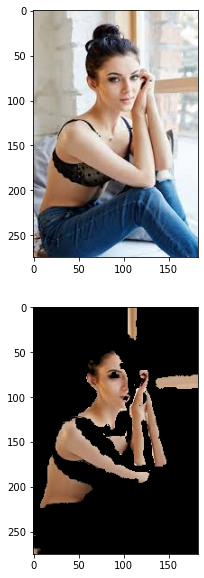

In [110]:
display_detected(img = original_img_2, detected_img = detected_img_2 , save_name="figures/test_bayes_9.png")

In [111]:
original_img_1, detected_img_1 = model_detector(img_test_path = "test_images/test10.jpeg", evaluate_method = 0, threshold=THRESHOLD_HISTO)
original_img_2, detected_img_2 = model_detector(img_test_path = "test_images/test10.jpeg", evaluate_method = 1, threshold=THRESHOLD_BAYES)

/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


Original image shape : (257, 659, 3)
Detected image shape : (257, 659, 3)


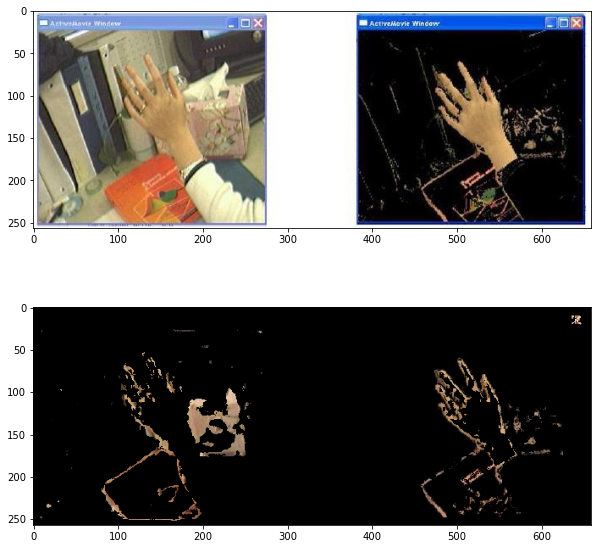

In [112]:
display_detected(img = original_img_1, detected_img = detected_img_1 , save_name="figures/test_histo_10.png")

Original image shape : (257, 659, 3)
Detected image shape : (257, 659, 3)


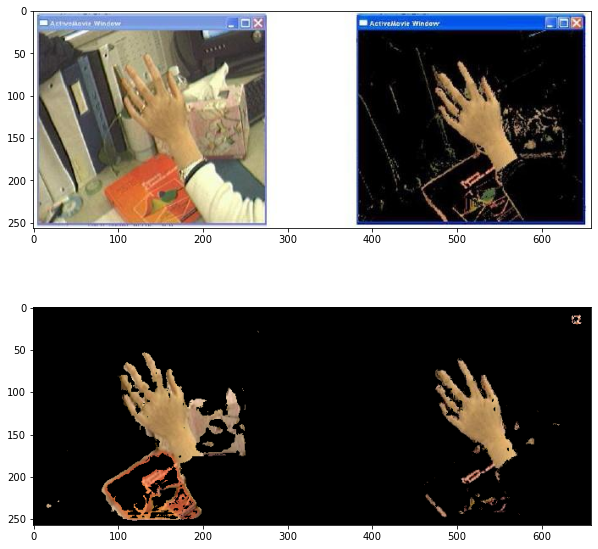

In [113]:
display_detected(img = original_img_2, detected_img = detected_img_2 , save_name="figures/test_bayes_10.png")